In [1]:
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import string
from pprint import pprint
import numpy as np
from nltk.tokenize import word_tokenize
import warnings
from matplotlib import pyplot as plt
from datetime import datetime

import torch

from transformers import AutoTokenizer, AutoModel

from gensim.models import KeyedVectors

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import ConvergenceWarning

from src.settings import POLISH_ANNOTATIONS_FPATH, DATA_DIR, MODELS_DIR, PLOTS_DIR

tqdm.pandas()

In [2]:
RANDOM_STATE = 42

EMB_VECTOR_SIZE = 100
EMB_WINDOW = 5
VOCAB_MIN_COUNT = 5

MIN_N_GRAM = 1
MAX_N_GRAM = 4

N_FOLDS = 5

EMB_EPOCHS = 20

In [3]:
def preprocess(text, stopwords):
    text = text.lower()
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text, language="polish")
    tokens = [word for word in tokens if word not in stopwords]
    if not any(tokens):
        return np.nan
    return " ".join(tokens)

with open(DATA_DIR / "polish.stopwords.txt", "r") as f:
    stop_words = set(f.readlines())

## Zbiór danych do klasyfikacji (tekst - numer zadania), korpus wzorcowy

In [4]:
korpus_wzorcowy = pd.read_json(POLISH_ANNOTATIONS_FPATH, lines=True)
korpus_wzorcowy

,start,end,text,doc_filepath,video_filename,task_label
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15
...,...,...,...,...,...,...
40350,248960,250320,[uderzanie w coś],/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40351,279560,291400,Kot zobaczył w akwarium rybkę. Podszedł i dał ...,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40352,291400,347120,"Zjadłam, zjadłam.",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13
40353,347120,356440,"Zając biegnie, zobaczył wiszące pranie. Wskocz...",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13


In [5]:
target_labels = korpus_wzorcowy["task_label"].astype(str).unique().tolist()
target_labels

['15', '24', '7', '17', '8', '13']

In [6]:
korpus_wzorcowy["text"].isna().sum(), korpus_wzorcowy["task_label"].isna().sum()

(0, 0)

In [7]:
korpus_wzorcowy_preprocessed = korpus_wzorcowy.copy()
korpus_wzorcowy_preprocessed["text_preprocessed"] = korpus_wzorcowy_preprocessed["text"].apply(preprocess, args=(stop_words,))

korpus_wzorcowy_preprocessed["text_preprocessed"][4:5]

4    jak ktoś zobaczy ale zignoruje ten znak to moż...
Name: text_preprocessed, dtype: object

In [8]:
korpus_wzorcowy_preprocessed.isna().sum()

start                0
end                  0
text                 0
doc_filepath         0
video_filename       0
task_label           0
text_preprocessed    2
dtype: int64

In [9]:
pl_data_preprocessed = korpus_wzorcowy_preprocessed.dropna()
pl_data_preprocessed.shape

(40353, 7)

## HerBERT

In [10]:
herbert_tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
herbert = AutoModel.from_pretrained("allegro/herbert-base-cased").to("cuda:0")

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.sso.sso_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def get_herbert_embedding(text: str, device: str = "cuda") -> np.ndarray:
    return herbert(
        **herbert_tokenizer.encode_plus(text,
            padding='longest',
            add_special_tokens=True,
            return_tensors='pt'
        ).to(device)
    ).pooler_output.to("cpu").detach().numpy()[0]

get_herbert_embedding("Ala ma kota").shape

(768,)

In [12]:
wzorcowy_X_herbert = pl_data_preprocessed["text_preprocessed"].progress_apply(get_herbert_embedding).to_numpy()

  0%|          | 0/40353 [00:00<?, ?it/s]

In [13]:
wzorcowy_X_herbert[0].shape

(768,)

## Word2Vec

In [14]:
word2vec = KeyedVectors.load(str(MODELS_DIR / "word2vec_100_3_polish.bin"))

In [15]:
def vectorize(sentence, keyed_vectors):
    words = sentence.split()
    words_vecs = [keyed_vectors[word] for word in words if word in keyed_vectors]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

def vectorize_data(X, emb_model):
    return np.array([vectorize(sentence, emb_model) for sentence in X])

vectorize("Ala ma kota", word2vec).shape

(100,)

In [16]:
wzorcowy_X_word2vec = pl_data_preprocessed["text_preprocessed"].progress_apply(vectorize, args=(word2vec,)).to_numpy()

  0%|          | 0/40353 [00:00<?, ?it/s]

In [17]:
wzorcowy_X_word2vec[0].shape

(100,)

In [18]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)


X, y = pl_data_preprocessed["text"].to_numpy(), pl_data_preprocessed["task_label"].to_numpy()

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
]

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

metrics_rows = []
for fold, (train_indices, test_indices) in enumerate(skf.split(X, y), start=1):
    wzorcowy_X_herbert_train, wzorcowy_y_train = wzorcowy_X_herbert.take(train_indices, axis=0), y.take(train_indices, axis=0)
    wzorcowy_X_herbert_test, wzorcowy_y_test = wzorcowy_X_herbert.take(test_indices, axis=0), y.take(test_indices, axis=0)

    wzorcowy_X_word2vec_train = wzorcowy_X_word2vec.take(train_indices, axis=0)
    wzorcowy_X_word2vec_test = wzorcowy_X_word2vec.take(test_indices, axis=0)
    
    wzorcowy_X_herbert_train = list(wzorcowy_X_herbert_train)
    wzorcowy_X_herbert_test = list(wzorcowy_X_herbert_test)
    
    wzorcowy_X_word2vec_train = list(wzorcowy_X_word2vec_train)
    wzorcowy_X_word2vec_test = list(wzorcowy_X_word2vec_test)

    clfs = classifiers.copy()
    for i_clf, (wzorcowy_herbert_clf, wzorcowy_word2vec_clf) in enumerate(zip(clfs, clfs), start=1):
        clf_name = wzorcowy_herbert_clf.__class__.__name__

        wzorcowy_herbert_clf.fit(wzorcowy_X_herbert_train, wzorcowy_y_train)
        wzorcowy_herbert_clf_preds = wzorcowy_herbert_clf.predict(wzorcowy_X_herbert_test)
        wzorcowy_herbert_clf_report = classification_report(wzorcowy_y_test, wzorcowy_herbert_clf_preds, output_dict=True, target_names=target_labels, zero_division=0)

        wzorcowy_word2vec_clf.fit(wzorcowy_X_word2vec_train, wzorcowy_y_train)
        wzorcowy_word2vec_clf_preds = wzorcowy_word2vec_clf.predict(wzorcowy_X_word2vec_test)
        wzorcowy_word2vec_clf_report = classification_report(wzorcowy_y_test, wzorcowy_word2vec_clf_preds, output_dict=True, target_names=target_labels, zero_division=0)

        metrics_rows.append({
            "EmbeddingModel": "HerBERT",
            "Classifier": clf_name,
            "Corpora": "Wzorcowy",
            "CvFold": fold,
            "Accuracy": wzorcowy_herbert_clf_report["accuracy"],
            "F1scoreMacro": wzorcowy_herbert_clf_report["macro avg"]["f1-score"],
            "PrecisionMacro": wzorcowy_herbert_clf_report["macro avg"]["precision"],
            "RecallMacro": wzorcowy_herbert_clf_report["macro avg"]["recall"],
            "Support": wzorcowy_herbert_clf_report["macro avg"]["support"],
        })
        metrics_rows.append({
            "EmbeddingModel": "Word2Vec",
            "Classifier": clf_name,
            "Corpora": "Wzorcowy",
            "CvFold": fold,
            "Accuracy": wzorcowy_word2vec_clf_report["accuracy"],
            "F1scoreMacro": wzorcowy_word2vec_clf_report["macro avg"]["f1-score"],
            "PrecisionMacro": wzorcowy_word2vec_clf_report["macro avg"]["precision"],
            "RecallMacro": wzorcowy_word2vec_clf_report["macro avg"]["recall"],
            "Support": wzorcowy_word2vec_clf_report["macro avg"]["support"],
        })

        print((
            "Fold: " + f"{fold}/{N_FOLDS}"
            " | Classifier: " + f"{i_clf:>2}/{len(classifiers)}"
        ).ljust(100, " "), end="\r")


print(f"\n\n{datetime.now()} | DONE!")

Fold: 5/5 | Classifier:  3/3                                                                        

2023-12-20 01:53:13.478524 | DONE!


In [19]:
evaluation_df = pd.DataFrame.from_records(metrics_rows)
evaluation_df

,EmbeddingModel,Classifier,Corpora,CvFold,Accuracy,F1scoreMacro,PrecisionMacro,RecallMacro,Support
0,HerBERT,LogisticRegression,Wzorcowy,1,0.621360,0.552414,0.589986,0.539366,8071.0
1,Word2Vec,LogisticRegression,Wzorcowy,1,0.608846,0.553963,0.612735,0.535807,8071.0
2,HerBERT,KNeighborsClassifier,Wzorcowy,1,0.600173,0.549127,0.569368,0.539107,8071.0
3,Word2Vec,KNeighborsClassifier,Wzorcowy,1,0.587164,0.549456,0.616086,0.524282,8071.0
4,HerBERT,DecisionTreeClassifier,Wzorcowy,1,0.483583,0.420267,0.420389,0.420505,8071.0
5,Word2Vec,DecisionTreeClassifier,Wzorcowy,1,0.515302,0.453951,0.462311,0.452162,8071.0
6,HerBERT,LogisticRegression,Wzorcowy,2,0.616033,0.537306,0.587022,0.525263,8071.0
7,Word2Vec,LogisticRegression,Wzorcowy,2,0.610457,0.550169,0.607468,0.534276,8071.0
8,HerBERT,KNeighborsClassifier,Wzorcowy,2,0.614174,0.564538,0.584471,0.554192,8071.0
9,Word2Vec,KNeighborsClassifier,Wzorcowy,2,0.585801,0.543060,0.600596,0.521418,8071.0


In [20]:
evaluation_df.to_csv(DATA_DIR / "nlp_lab_9_clf_pretrained_emb_evaluation.csv", index=False)

In [21]:
evaluation_df = pd.read_csv(DATA_DIR / "nlp_lab_9_clf_pretrained_emb_evaluation.csv")

In [30]:
evaluation_df["EmbeddingModel"] = evaluation_df["EmbeddingModel"].apply(lambda s: s + "\n(pretrained)")

In [31]:
XTICKS_ROTATION = 0

# Adding score values on top of each bar

def add_bar_labels(ax):
    """
    Add labels on top of each bar in seaborn barplot.
    """
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + (p.get_height() * 0.8)
        value = '{:.3f}'.format(p.get_height())
        if value == '{:.3f}'.format(0):
            continue
        ax.text(_x, _y, value, ha="center", va='bottom', fontsize=8)

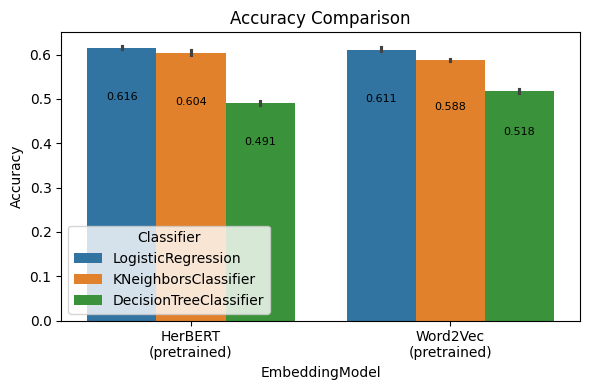

In [32]:
# Plotting with score values
fig = plt.figure(figsize=(6, 4))

# Plot for Accuracy
sns.barplot(data=evaluation_df, x='EmbeddingModel', y='Accuracy', hue='Classifier')
plt.title('Accuracy Comparison')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(fig.get_axes()[0])

plt.tight_layout()
plt.show()

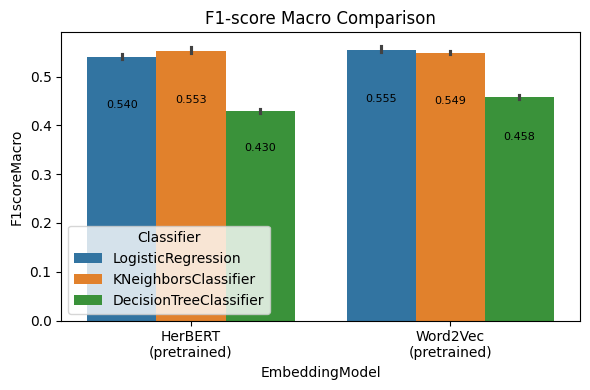

In [33]:
# Plotting with score values
fig = plt.figure(figsize=(6, 4))

# Plot for Accuracy
sns.barplot(data=evaluation_df, x='EmbeddingModel', y='F1scoreMacro', hue='Classifier')
plt.title('F1-score Macro Comparison')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(fig.get_axes()[0])

plt.tight_layout()
plt.show()

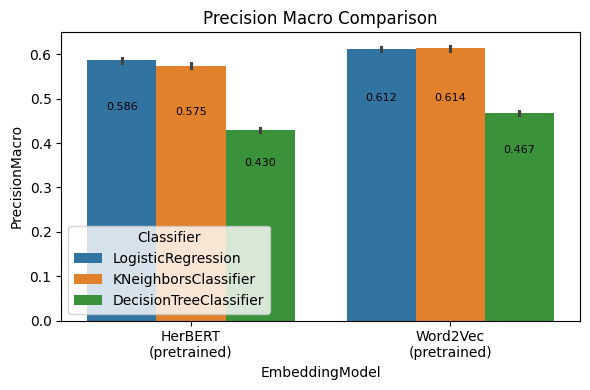

In [34]:
# Plotting with score values
fig = plt.figure(figsize=(6, 4))

# Plot for Accuracy
sns.barplot(data=evaluation_df, x='EmbeddingModel', y='PrecisionMacro', hue='Classifier')
plt.title('Precision Macro Comparison')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(fig.get_axes()[0])

plt.tight_layout()
plt.show()

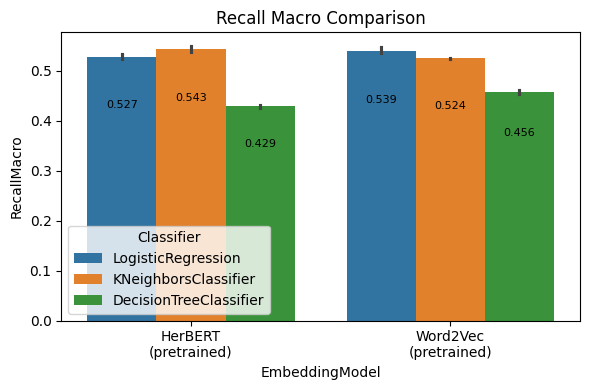

In [35]:
# Plotting with score values
fig = plt.figure(figsize=(6, 4))

# Plot for Accuracy
sns.barplot(data=evaluation_df, x='EmbeddingModel', y='RecallMacro', hue='Classifier')
plt.title('Recall Macro Comparison')
plt.xticks(rotation=XTICKS_ROTATION)
add_bar_labels(fig.get_axes()[0])

plt.tight_layout()
plt.show()